Размер датасета: (10000, 10)
Колонки: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']
=== ОСНОВНАЯ ИНФОРМАЦИЯ ===
Количество записей: 10000
Количество признаков: 10

Типы данных:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

Пропуски:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Дубликаты: 0
Статистика 

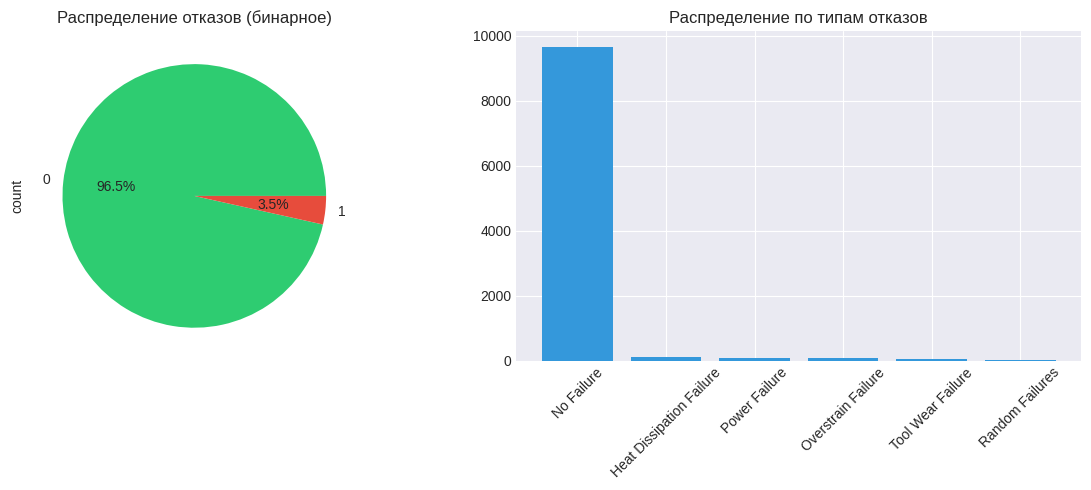

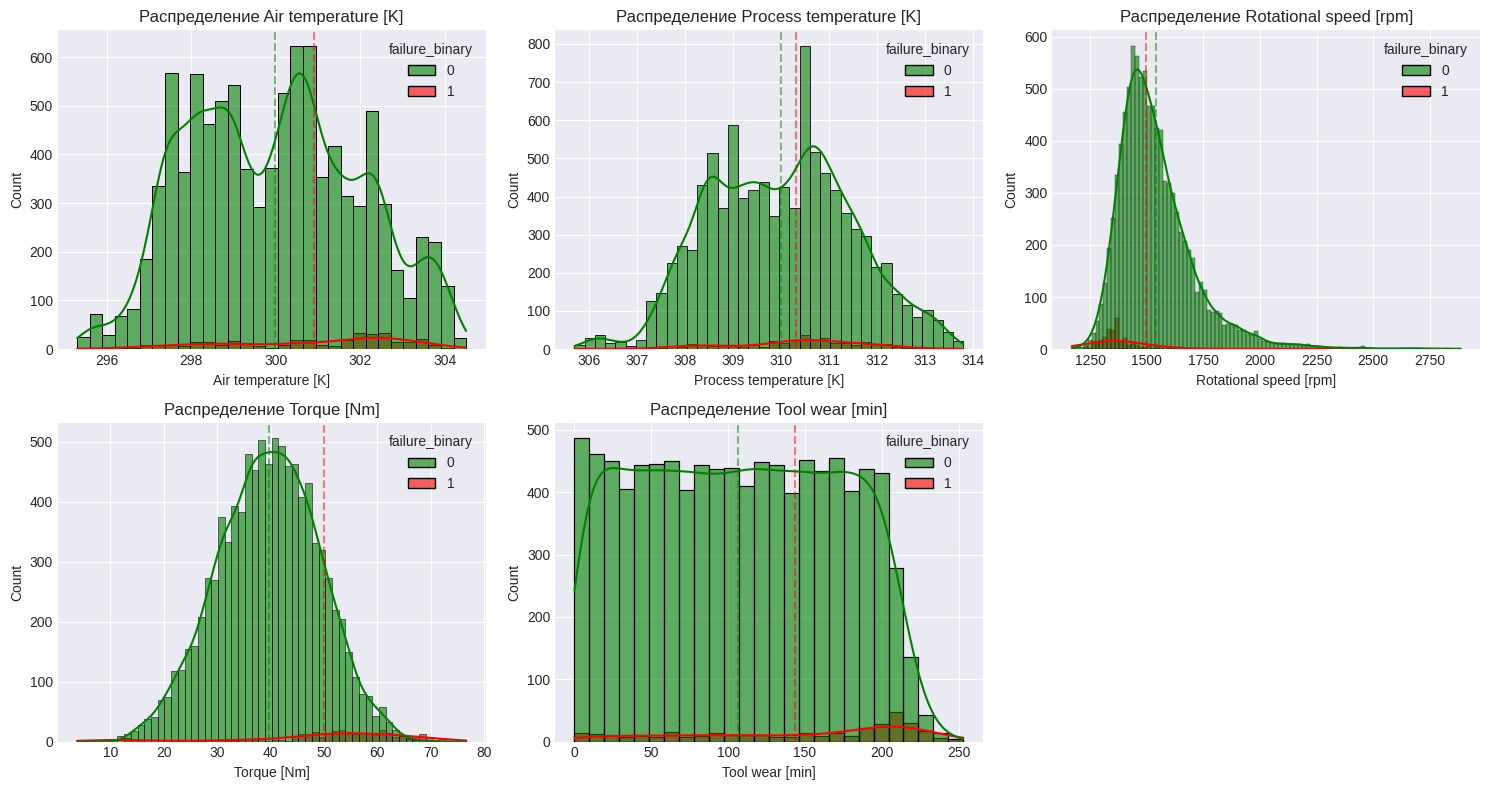

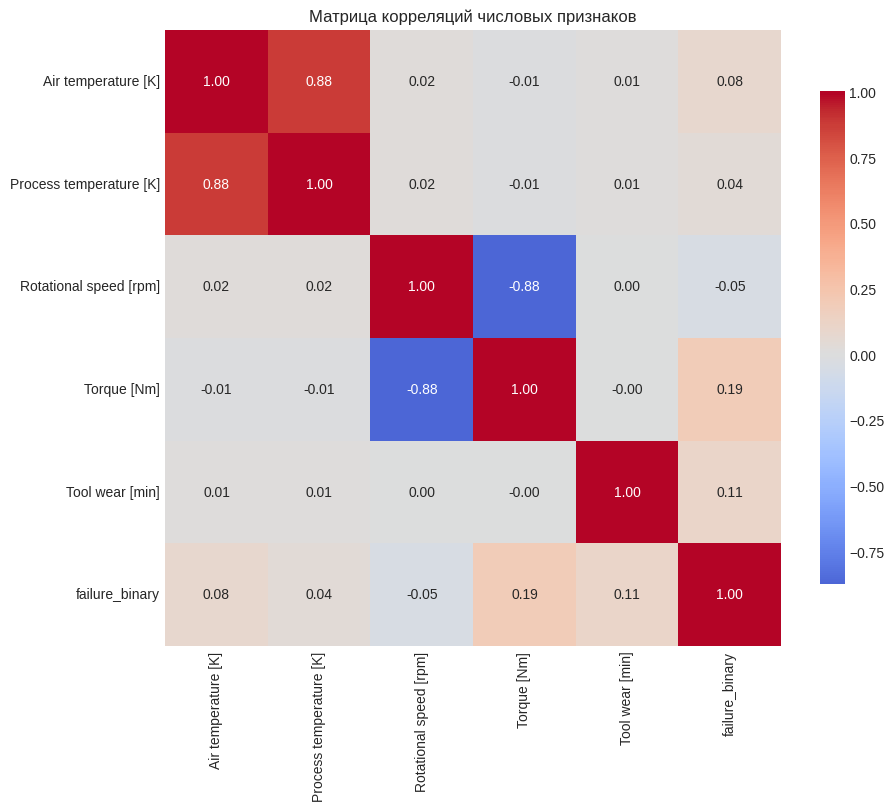

Высокие корреляции (|r| > 0.7):
Air temperature [K] - Process temperature [K]: 0.876
Rotational speed [rpm] - Torque [Nm]: -0.875
=== АНАЛИЗ ТИПОВ ОБОРУДОВАНИЯ ===
      total_count  failure_rate  failure_count
Type                                          
H            1003         0.024             24
L            6000         0.040            243
M            2997         0.027             81


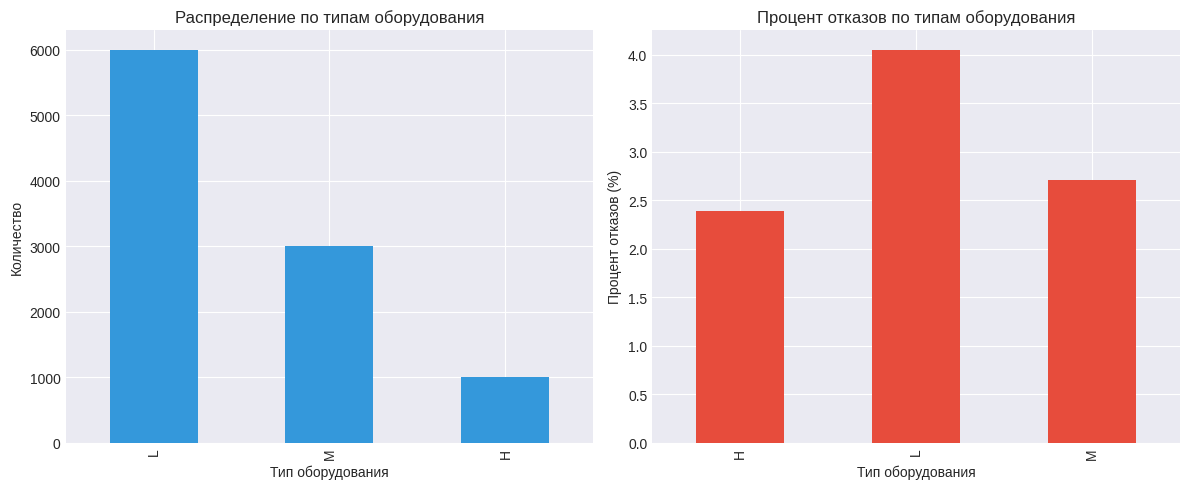

Air temperature [K]: 0 выбросов (0.00%)
Process temperature [K]: 0 выбросов (0.00%)
Rotational speed [rpm]: 418 выбросов (4.18%)
Torque [Nm]: 69 выбросов (0.69%)
Tool wear [min]: 0 выбросов (0.00%)


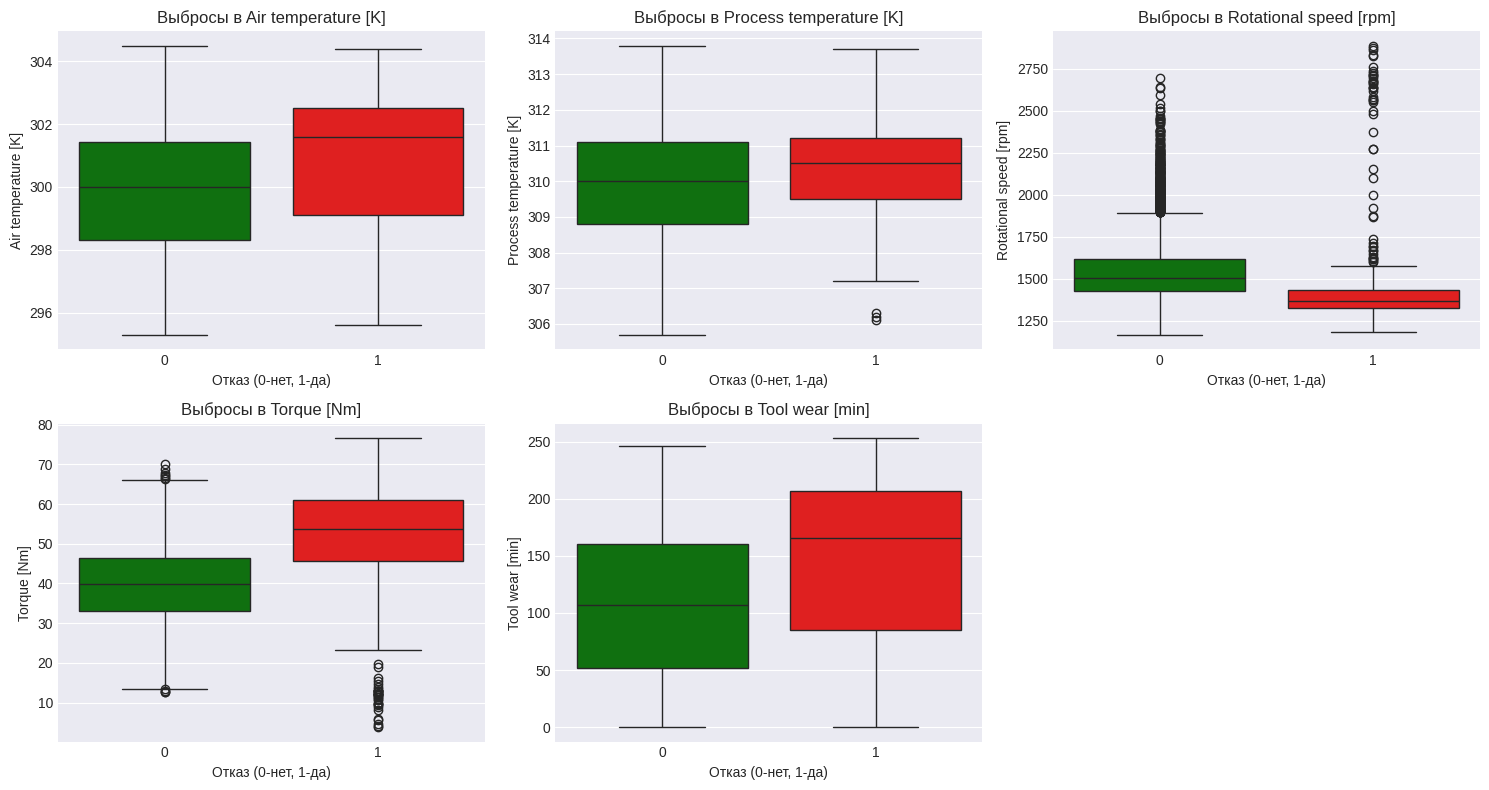

=== СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ ===
Создан признак: temp_difference
Создан признак: torque_speed_ratio
Создан признак: wear_category
Создан признак: power_estimate
Создан признак: temp_wear_interaction
Кодирование завершено
Новые колонки: ['type_H', 'type_L', 'type_M']
Размерность признаков: (10000, 13)
Размерность целевой: (10000,)
Разделение данных:
Train: (8000, 13), (8000,)
Test: (2000, 13), (2000,)

Распределение классов в train: 3.48%
Распределение классов в test: 3.50%
Масштабирование завершено
Данные сохранены:
  - ../data/processed/X_train.csv
  - ../data/processed/X_test.csv
  - ../data/processed/y_train.csv
  - ../data/processed/y_test.csv
  - ../data/processed/scaler.pkl
  - ../data/processed/features.pkl

=== ВЫВОДЫ ИЗ EDA ===

1. ДИСБАЛАНС КЛАССОВ:
   - Доля отказов: 3.41% (сильный дисбаланс)
   - Требуется специальная обработка

2. ВАЖНЫЕ ПРИЗНАКИ:
   - Tool wear: Прямая корреляция с отказами
   - Torque: Двухмодальное распределение
   - Temperature difference: Новый значим

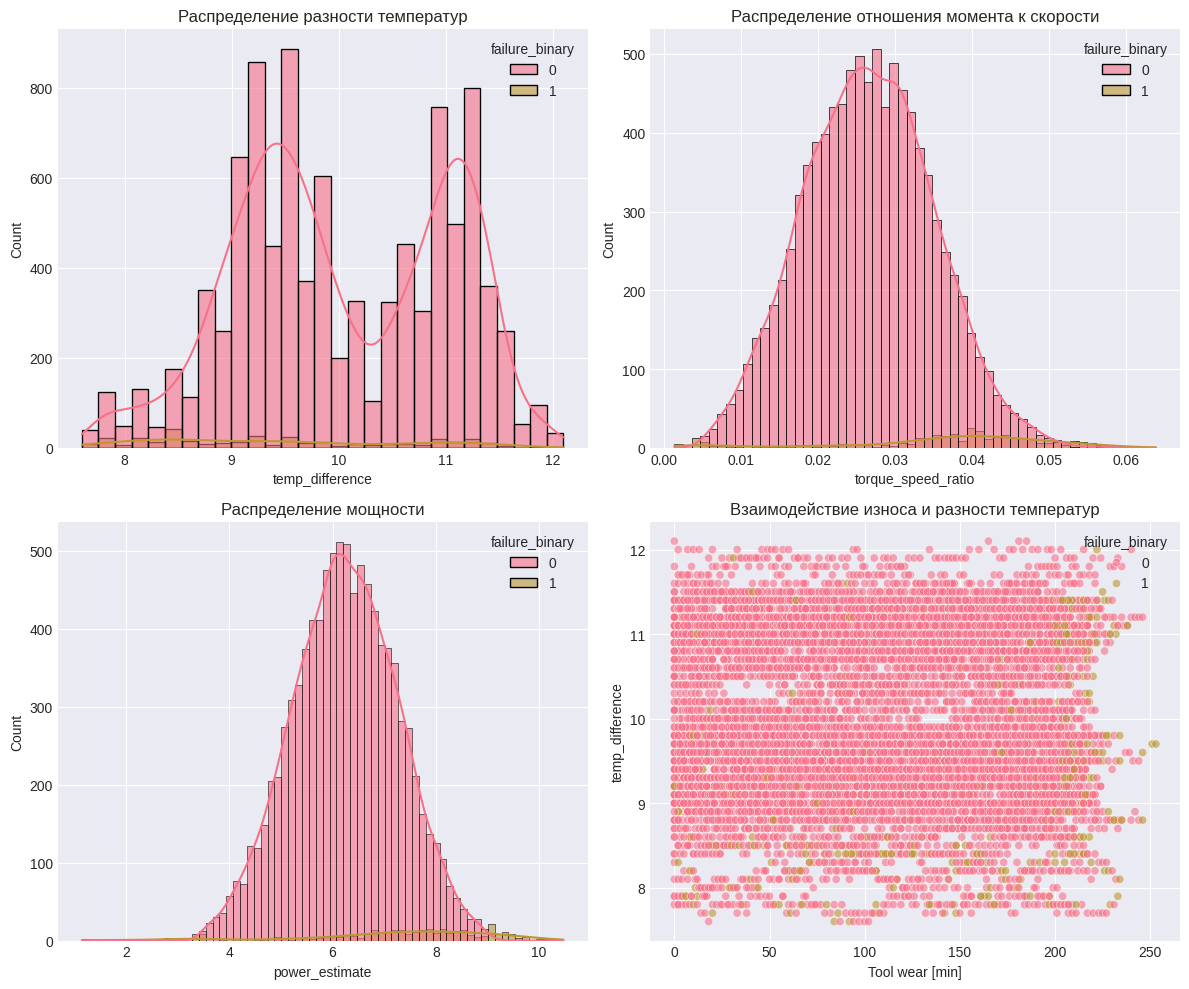

In [ ]:
# %% [markdown]
# # 1. Подготовка данных для системы предиктивного обслуживания
#
# ## Цели ноутбука:
# 1. Загрузка и первичное исследование датасета
# 2. Exploratory Data Analysis (EDA)
# 3. Предобработка и очистка данных
# 4. Feature Engineering
# 5. Сохранение подготовленных данных

# %% [markdown]
# ## 1.1 Импорт библиотек
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# %% [markdown]
# ## 1.2 Загрузка данных
# %%
# Загрузка датасета Predictive Maintenance
df = pd.read_csv('predictive_maintenance.csv')
print(f"Размер датасета: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")

# Просмотр первых строк
df.head()

# %% [markdown]
# ## 1.3 Основная информация о данных
# %%
# Основная информация
print("=== ОСНОВНАЯ ИНФОРМАЦИЯ ===")
print(f"Количество записей: {len(df)}")
print(f"Количество признаков: {len(df.columns)}")
print("\nТипы данных:")
print(df.dtypes)
print("\nПропуски:")
print(df.isnull().sum())
print("\nДубликаты:", df.duplicated().sum())

# %% [markdown]
# ## 1.4 Статистика числовых признаков
# %%
# Статистика числовых признаков
numeric_cols = ['Air temperature [K]', 'Process temperature [K]',
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
print("Статистика числовых признаков:")
print(df[numeric_cols].describe().T)

# %% [markdown]
# ## 1.5 Анализ целевой переменной
# %%
# Создание бинарной целевой переменной
df['failure_binary'] = df['Failure Type'].apply(lambda x: 0 if x == 'No Failure' else 1)

print("=== АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")
print("\nРаспределение отказов:")
print(df['failure_binary'].value_counts())
print(f"\nДоля отказов: {df['failure_binary'].mean():.2%}")

# Визуализация распределения
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Бинарная целевая
df['failure_binary'].value_counts().plot.pie(
    autopct='%1.1f%%',
    ax=axes[0],
    colors=['#2ecc71', '#e74c3c']
)
axes[0].set_title('Распределение отказов (бинарное)')

# Типы отказов
failure_counts = df['Failure Type'].value_counts()
axes[1].bar(failure_counts.index, failure_counts.values, color='#3498db')
axes[1].set_title('Распределение по типам отказов')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 1.6 Анализ числовых признаков
# %%
# Гистограммы числовых признаков
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, hue='failure_binary',
                 ax=axes[i], kde=True, alpha=0.6, palette={0: 'green', 1: 'red'})
    axes[i].set_title(f'Распределение {col}')

    # Добавление статистики
    mean_no_fail = df[df['failure_binary'] == 0][col].mean()
    mean_fail = df[df['failure_binary'] == 1][col].mean()
    axes[i].axvline(mean_no_fail, color='green', linestyle='--', alpha=0.5)
    axes[i].axvline(mean_fail, color='red', linestyle='--', alpha=0.5)

# Удаление лишнего subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 1.7 Корреляционный анализ
# %%
# Матрица корреляций
corr_matrix = df[numeric_cols + ['failure_binary']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций числовых признаков')
plt.show()

# Анализ высоких корреляций
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j],
                            corr_matrix.iloc[i, j]))

print("Высокие корреляции (|r| > 0.7):")
for pair in high_corr:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

# %% [markdown]
# ## 1.8 Анализ категориальных признаков
# %%
# Анализ типа оборудования
print("=== АНАЛИЗ ТИПОВ ОБОРУДОВАНИЯ ===")
type_analysis = df.groupby('Type').agg({
    'failure_binary': ['count', 'mean', 'sum']
}).round(3)
type_analysis.columns = ['total_count', 'failure_rate', 'failure_count']
print(type_analysis)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Распределение по типам
df['Type'].value_counts().plot.bar(ax=axes[0], color='#3498db')
axes[0].set_title('Распределение по типам оборудования')
axes[0].set_xlabel('Тип оборудования')
axes[0].set_ylabel('Количество')

# Процент отказов по типам
type_failure_rate = df.groupby('Type')['failure_binary'].mean() * 100
type_failure_rate.plot.bar(ax=axes[1], color='#e74c3c')
axes[1].set_title('Процент отказов по типам оборудования')
axes[1].set_xlabel('Тип оборудования')
axes[1].set_ylabel('Процент отказов (%)')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 1.9 Анализ выбросов
# %%
# Boxplot для выявления выбросов
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    # Преобразуем failure_binary в строковый тип для корректной работы с palette
    sns.boxplot(data=df, x=df['failure_binary'].astype(str), y=col, ax=axes[i],
                palette={'0': 'green', '1': 'red'})
    axes[i].set_title(f'Выбросы в {col}')
    axes[i].set_xlabel('Отказ (0-нет, 1-да)')

    # Расчет выбросов по IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(df):.2%})")

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 1.10 Feature Engineering
# %%
# Создание новых признаков
print("=== СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ ===")

# 1. Разность температур
df['temp_difference'] = df['Process temperature [K]'] - df['Air temperature [K]']
print(f"Создан признак: temp_difference")

# 2. Отношение крутящего момента к скорости
df['torque_speed_ratio'] = df['Torque [Nm]'] / df['Rotational speed [rpm]']
print(f"Создан признак: torque_speed_ratio")

# 3. Категория износа инструмента
def categorize_wear(wear):
    if wear < 50:
        return 'low'
    elif wear < 150:
        return 'medium'
    else:
        return 'high'

df['wear_category'] = df['Tool wear [min]'].apply(categorize_wear)
print(f"Создан признак: wear_category")

# 4. Мощность (приблизительная)
df['power_estimate'] = df['Torque [Nm]'] * df['Rotational speed [rpm]'] / 9549.3
print(f"Создан признак: power_estimate")

# 5. Взаимодействие температуры и износа
df['temp_wear_interaction'] = df['temp_difference'] * df['Tool wear [min]']
print(f"Создан признак: temp_wear_interaction")

# %% [markdown]
# ## 1.11 Кодирование категориальных признаков
# %%
# One-Hot Encoding для Type
type_dummies = pd.get_dummies(df['Type'], prefix='type')
df = pd.concat([df, type_dummies], axis=1)

# Label Encoding для wear_category (если нужно для деревьев)
wear_mapping = {'low': 0, 'medium': 1, 'high': 2}
df['wear_category_encoded'] = df['wear_category'].map(wear_mapping)

print("Кодирование завершено")
print(f"Новые колонки: {[col for col in df.columns if col.startswith('type_')]}")

# %% [markdown]
# ## 1.12 Подготовка финального датасета
# %%
# Выбор финальных признаков
features = [
    # Исходные признаки
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',

    # Инженерные признаки
    'temp_difference',
    'torque_speed_ratio',
    'power_estimate',
    'temp_wear_interaction',

    # Кодированные категориальные
    'type_L', 'type_M', 'type_H',
    'wear_category_encoded'
]

target = 'failure_binary'

X = df[features]
y = df[target]

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой: {y.shape}")

# %% [markdown]
# ## 1.13 Разделение данных
# %%
# Стратифицированное разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Разделение данных:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# Проверка распределения классов
print(f"\nРаспределение классов в train: {y_train.mean():.2%}")
print(f"Распределение классов в test: {y_test.mean():.2%}")

# %% [markdown]
# ## 1.14 Масштабирование признаков
# %%
# Масштабирование только числовых признаков
numeric_features = [col for col in features if col not in ['type_L', 'type_M', 'type_H']]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print("Масштабирование завершено")

# %% [markdown]
# ## 1.15 Сохранение подготовленных данных
# %%
# Сохранение подготовленных данных
import pickle
import os

# Создание директории для сохранения
os.makedirs('../data/processed', exist_ok=True)

# Сохранение данных
X_train_scaled.to_csv('../data/processed/X_train.csv', index=False)
X_test_scaled.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Сохранение scaler
with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Сохранение списка признаков
with open('../data/processed/features.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Данные сохранены:")
print("  - ../data/processed/X_train.csv")
print("  - ../data/processed/X_test.csv")
print("  - ../data/processed/y_train.csv")
print("  - ../data/processed/y_test.csv")
print("  - ../data/processed/scaler.pkl")
print("  - ../data/processed/features.pkl")

# %% [markdown]
# ## 1.16 Выводы EDA
# %%
# Выводы из анализа данных
print("""
=== ВЫВОДЫ ИЗ EDA ===

1. ДИСБАЛАНС КЛАССОВ:
   - Доля отказов: 3.41% (сильный дисбаланс)
   - Требуется специальная обработка

2. ВАЖНЫЕ ПРИЗНАКИ:
   - Tool wear: Прямая корреляция с отказами
   - Torque: Двухмодальное распределение
   - Temperature difference: Новый значимый признак

3. ВЫСОКИЕ КОРРЕЛЯЦИИ:
   - Air temp & Process temp: 0.88
   - Torque & Rotational speed: -0.88
   - Учитывать при построении моделей

4. ТИП ОБОРУДОВАНИЯ:
   - Type H имеет наибольший процент отказов (4.0%)
   - Важный категориальный признак

5. FEATURE ENGINEERING:
   - Создано 5 новых признаков
   - Наиболее перспективные: temp_difference, torque_speed_ratio

6. РЕКОМЕНДАЦИИ:
   - Использовать методы борьбы с дисбалансом
   - Учитывать высокие корреляции признаков
   - Использовать созданные инженерные признаки
""")

# %% [markdown]
# ## 1.17 Визуализация новых признаков
# %%
# Визуализация созданных признаков
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Разность температур
sns.histplot(data=df, x='temp_difference', hue='failure_binary',
             ax=axes[0, 0], kde=True, alpha=0.6)
axes[0, 0].set_title('Распределение разности температур')

# 2. Отношение момента к скорости
sns.histplot(data=df, x='torque_speed_ratio', hue='failure_binary',
             ax=axes[0, 1], kde=True, alpha=0.6)
axes[0, 1].set_title('Распределение отношения момента к скорости')

# 3. Мощность
sns.histplot(data=df, x='power_estimate', hue='failure_binary',
             ax=axes[1, 0], kde=True, alpha=0.6)
axes[1, 0].set_title('Распределение мощности')

# 4. Взаимодействие температуры и износа
sns.scatterplot(data=df, x='Tool wear [min]', y='temp_difference',
                hue='failure_binary', ax=axes[1, 1], alpha=0.6)
axes[1, 1].set_title('Взаимодействие износа и разности температур')

plt.tight_layout()
plt.show()